In [20]:
# Dev notebook for transforms, vizualisation of the dataset

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, StratifiedKFold
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from Lamp.AttrDict.AttrDict import *
from Lamp.Model.Dataloader import *
from Lamp.Model.Resnet import *


In [21]:
cfg_path = 'Config/MAR_RESNET34_PADDED_64_ALL.yaml'

inputs = AttrDict.from_yaml_path(cfg_path)
inputs

{'ModelName': 'MAR_RESNET34_PADDED_64_ALL',
 'PathSave': 'Models/outputs/',
 'LoadPath': 'Dataset/train_mar.csv',
 'CheckpointName': 'checkpoint.pt',
 'CheckpointFreq': 5,
 'NSamples': 1000,
 'NEpochs': 200,
 'BatchSize': 32,
 'TrainTestSplit': 0.95,
 'KFold': 5,
 'Seed': 0,
 'Model': {'Layers': [3, 4, 6, 3], 'OutClasses': 5, 'Channels': 1},
 'TransformTrain': {'Padding': {'out_shape': 64},
  'VerticalFlip': {'p': 0.5},
  'HorizontalFlip': {'p': 0.5},
  'Rotation': {'min': -90, 'max': 90}},
 'TransformTest': {'Padding': {'out_shape': 64}},
 'Optimizer': {'lr': 0.001, 'weight_decay': 1e-06},
 'Scheduler': {'gamma': 0.95}}

In [22]:
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) # Workspace path to Cuttings_Characterisation 

path_model = f"{root_path}/{inputs.PathSave}/{inputs.ModelName}"

path_load_data = f"{root_path}/{inputs.LoadPath}" # Path for the .csv file

if os.path.isdir(path_model) is False: # Create new folder for the model
    os.mkdir(path_model)


In [23]:
path_checkpoint = f"{path_model}/{inputs.CheckpointName}"

if os.path.isfile(path_checkpoint): # Remove checkpoint file at the end of the training
    os.remove(path_checkpoint)

In [24]:
i_ = 1
model_name = f"model_{i_}.pt"
save_model_path = f"{path_model}/{model_name}"

In [25]:
save_model_path

'c:\\Users\\nilso\\Documents\\EPFL\\MA4\\PDS Turberg\\Rock_Cuttings_Characterisation\\Cuttings_Characterisation/Models/outputs//MAR_RESNET34_PADDED_64_ALL/model_1.pt'

In [26]:
def resnet34(channels=3, num_classes=1000):
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock,layers,channels=channels,num_classes=num_classes)
    return model

net = resnet34(channels=1,num_classes=5)

In [27]:
dataframe = pd.read_csv(path_load_data,index_col=0)

# Train Test Split
train_dataframe, test_dataframe = train_test_split(dataframe, test_size=(1 - inputs.TrainTestSplit),stratify=dataframe['Label'], random_state=inputs.Seed)

# Reset Index
train_dataframe = train_dataframe.reset_index(drop=True)
test_dataframe = test_dataframe.reset_index(drop=True)

# Samples
test_dataframe = test_dataframe.groupby('Label').sample(40,replace=True,random_state=inputs.Seed).reset_index(drop=True)
train_dataframe = train_dataframe.groupby('Label').sample(inputs.NSamples,replace=True,random_state=inputs.Seed).reset_index(drop=True)

In [28]:
X = train_dataframe.iloc[:,:-1]
y = train_dataframe.iloc[:,-1]

In [29]:
k = 5
kf = StratifiedKFold(n_splits=k, random_state=None)

In [30]:
for train_index, test_index in kf.split(X,y):
    print(len(train_index), len(test_index))

4000 1000
4000 1000
4000 1000
4000 1000
4000 1000


In [31]:
dict_transform = {
    "Padding":Padding,
    "VerticalFlip":tf.RandomVerticalFlip,
    "HorizontalFlip":tf.RandomHorizontalFlip,
    "Rotation":tf.RandomRotation,
    "CenterCrop":tf.CenterCrop,
    "Resize":tf.Resize,
    }

In [32]:
[dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTrain.items()] 


 RandomVerticalFlip(p=0.5),
 RandomHorizontalFlip(p=0.5),
 RandomRotation(degrees=[-90.0, 90.0], resample=False, expand=False)]

In [33]:
transforms_train = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTrain.items()] 
    )

transforms_test = Transforms(
    [dict_transform[key]([k for k in item.values()] if len(item.values()) > 1 else [k for k in item.values()][0]) for key, item in inputs.TransformTest.items()] 
    )

In [34]:
trainDataset = Dataset(train_dataframe.loc[train_index,:].reset_index(drop=True),transforms=transforms_train.get_transforms())
testDataset = Dataset(train_dataframe.loc[test_index,:].reset_index(drop=True),transforms=transforms_test.get_transforms())

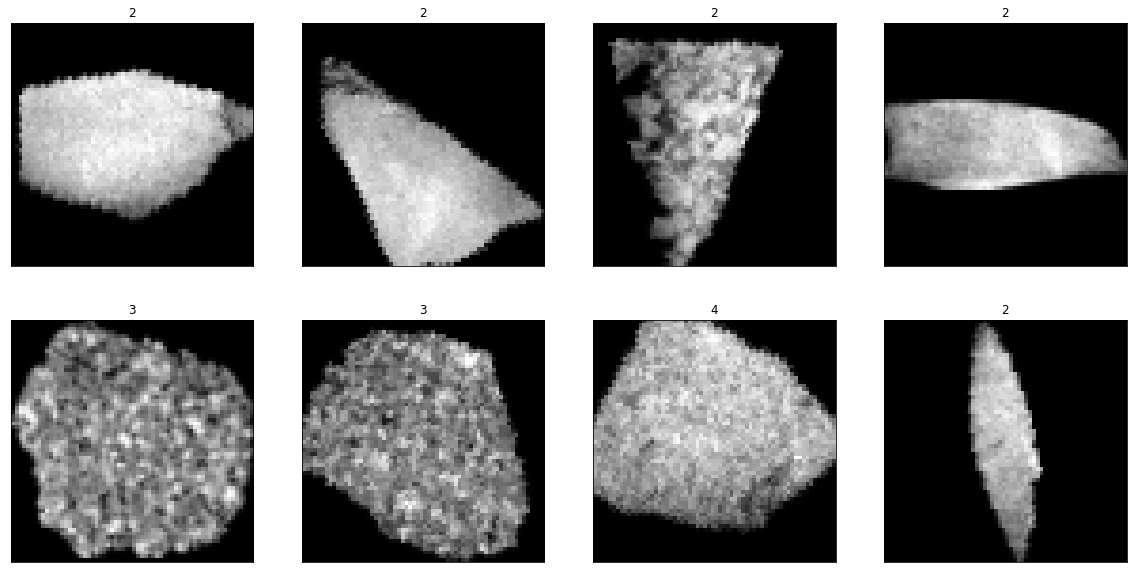

In [35]:
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size,shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,4,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

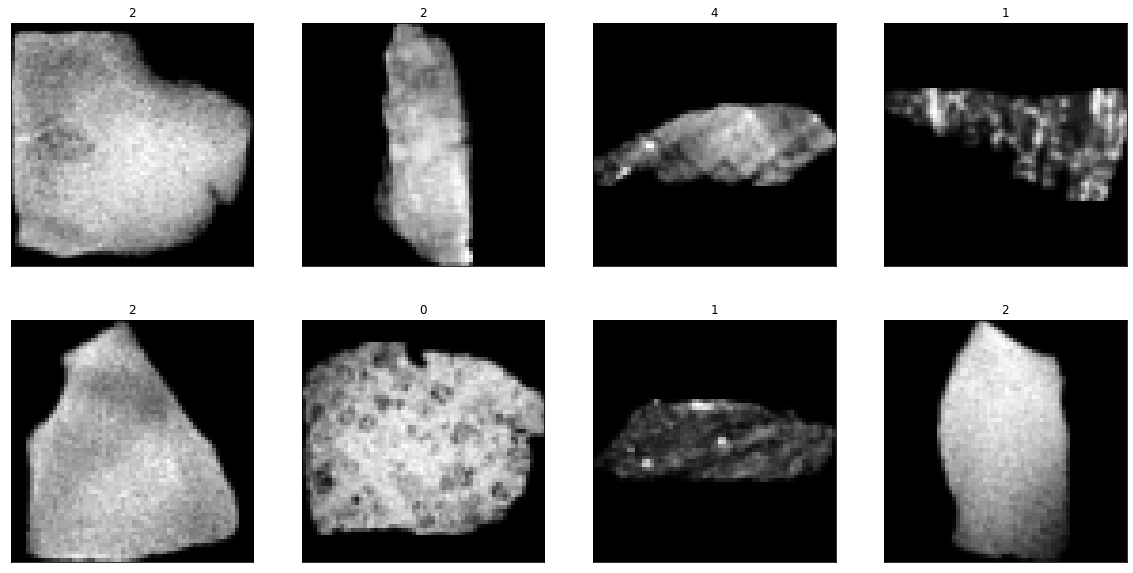

In [36]:
batch_size = 8
test_dataloader = torch.utils.data.DataLoader(testDataset, batch_size=batch_size,shuffle=True)

test_features, test_labels = next(iter(test_dataloader))

fig, axs = plt.subplots(2,4,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(test_features.numpy()[i_][0],cmap='gray')
    ax.set_title(test_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

## Generation of samples 
This will illustrate the different dataset on which the networks will be trained 

### Train for BBOX dataset

In [37]:
dataframe = pd.read_csv('../Dataset/train_bbox.csv',index_col=0)
dataframe = dataframe.groupby('Label').sample(10,replace=True,random_state=0).reset_index(drop=True)

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

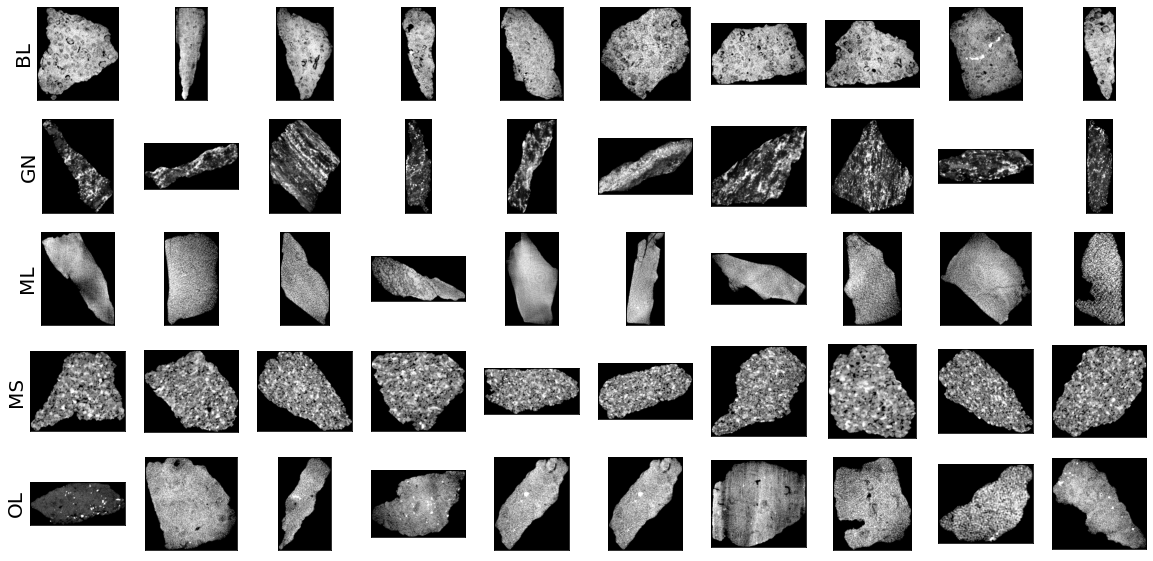

In [39]:
# Raw 

transforms = tf.Compose(
        [   
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    im, label = trainDataset.__getitem__(i_)

    ax.imshow(im[0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(im[0].numpy())
    im.save(f"samples/Train/bbox/raw/{dict_[int(label.numpy())]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[int(label.numpy())]}", fontsize=20)

plt.savefig(f"samples/Train/bbox/raw.png")

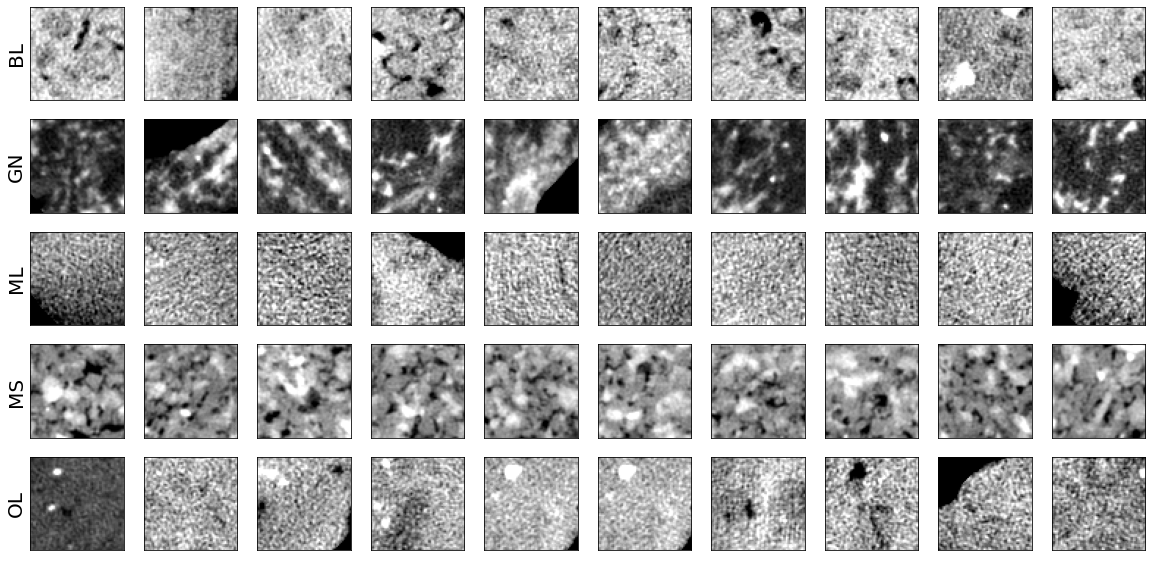

In [40]:
# Cropped 

transforms = tf.Compose(
        [   
            tf.CenterCrop(64),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/bbox/cropped/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/bbox/cropped.png")

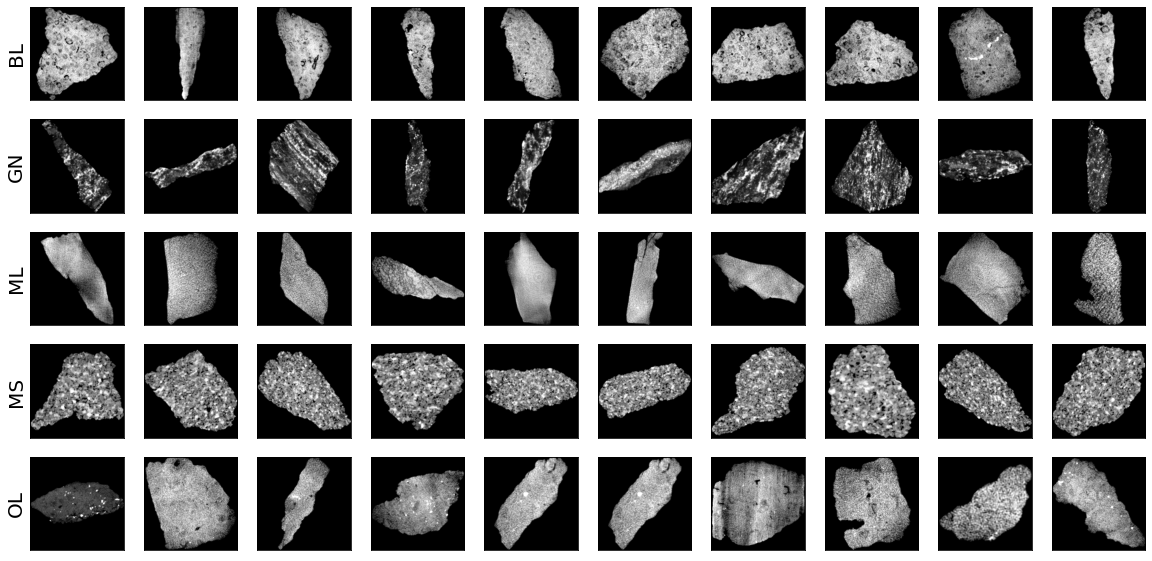

In [41]:
# Padded

transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/bbox/padded/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/bbox/padded.png")

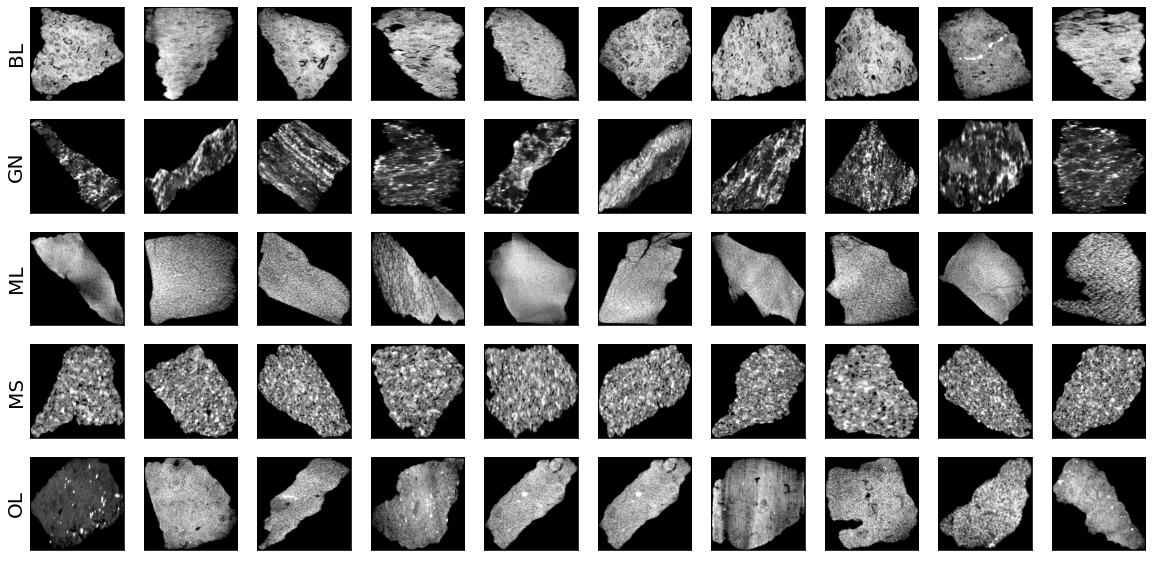

In [42]:
# Resized

transforms = tf.Compose(
        [   
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/bbox/resized/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/bbox/resized.png")

### Train for MAR dataset

In [43]:
dataframe = pd.read_csv('../Dataset/train_mar.csv',index_col=0)
dataframe = dataframe.groupby('Label').sample(10,replace=True,random_state=0).reset_index(drop=True)

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

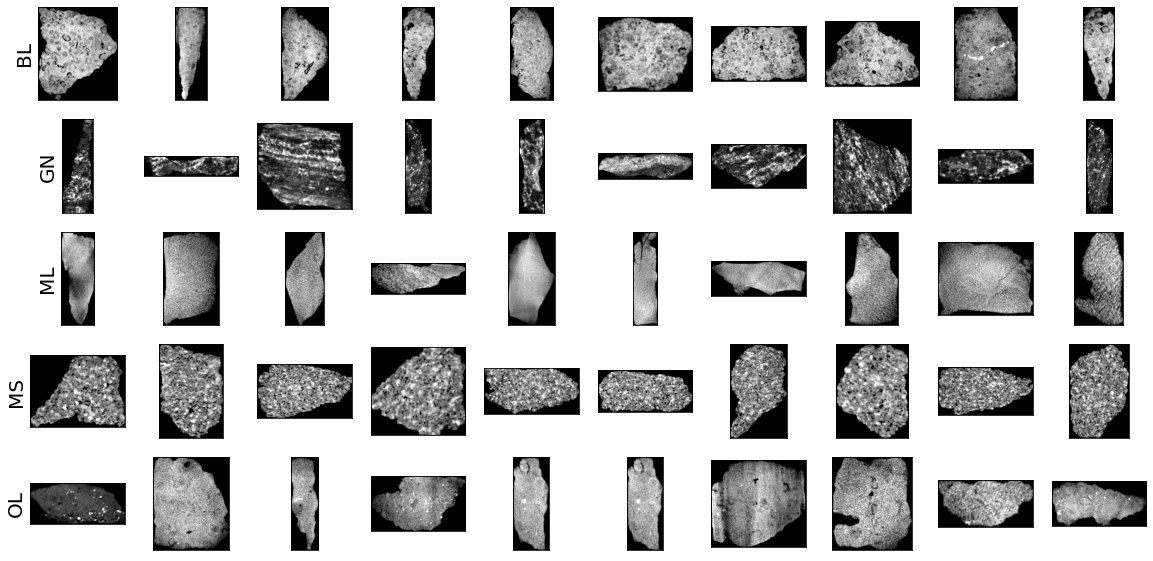

In [44]:
# Raw 

transforms = tf.Compose(
        [   
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    im, label = trainDataset.__getitem__(i_)

    ax.imshow(im[0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(im[0].numpy())
    im.save(f"samples/Train/mar/raw/{dict_[int(label.numpy())]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[int(label.numpy())]}", fontsize=20)

plt.savefig(f"samples/Train/mar/raw.png")

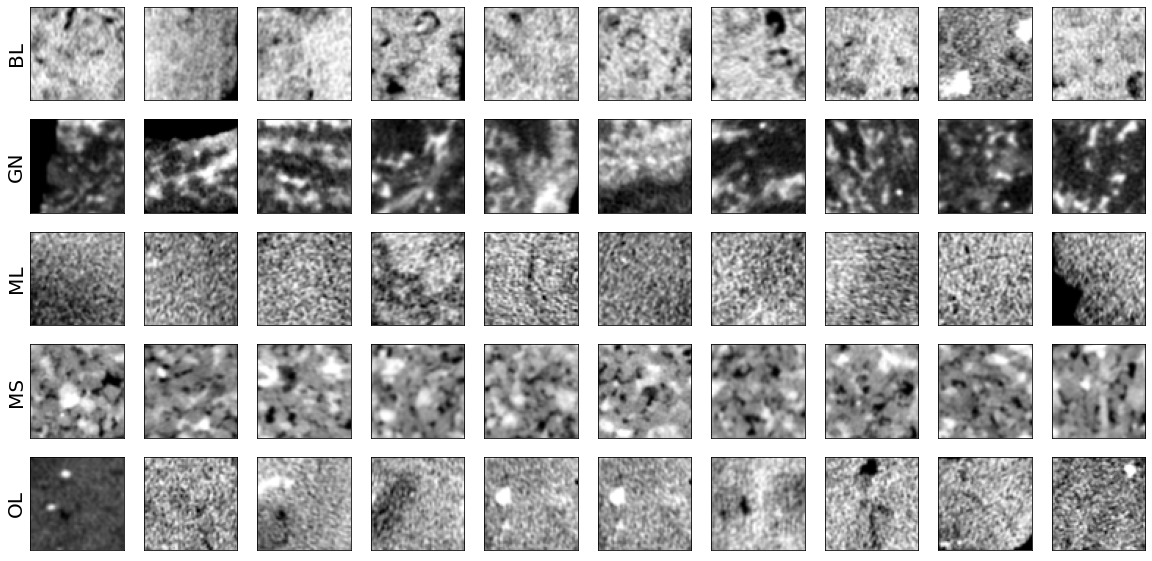

In [45]:
# Cropped 

transforms = tf.Compose(
        [   
            tf.CenterCrop(64),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/mar/cropped/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/mar/cropped.png")

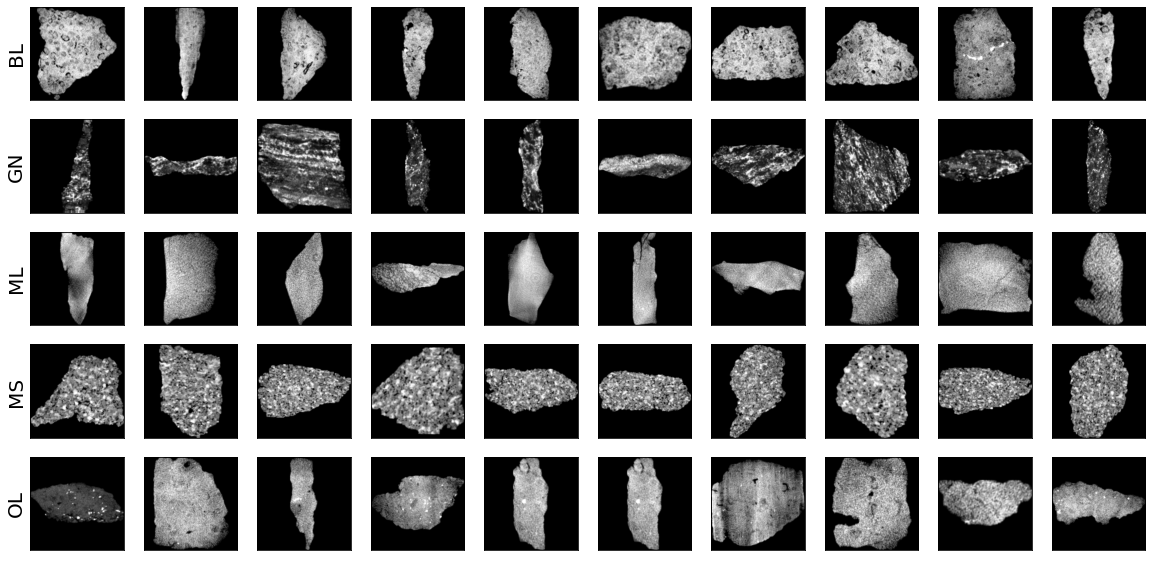

In [46]:
# Padded

transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/mar/padded/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/mar/padded.png")

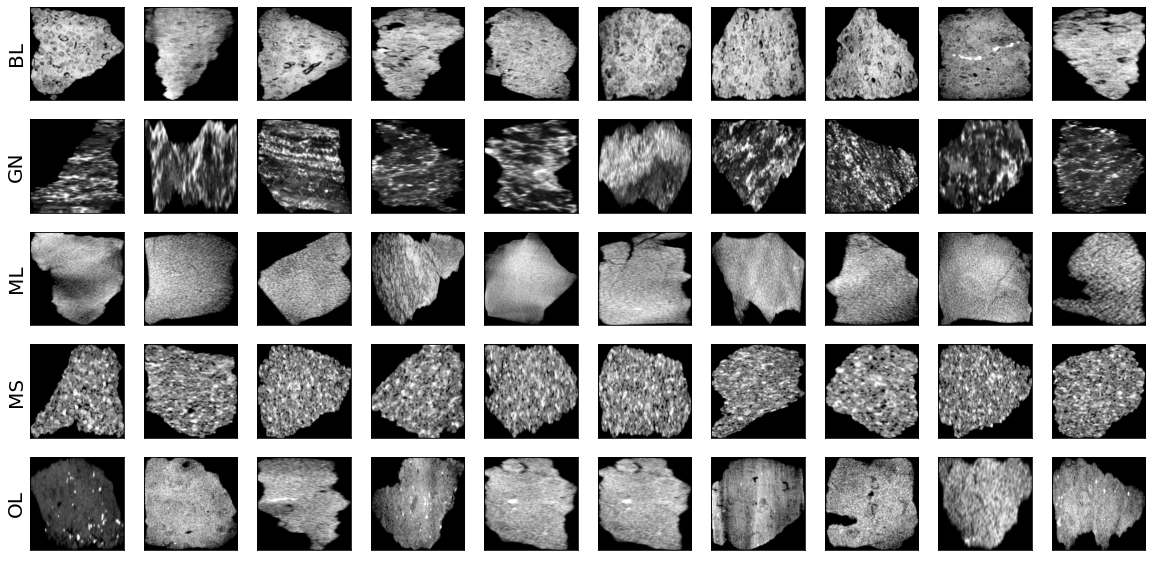

In [47]:
# Resized

transforms = tf.Compose(
        [   
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*5)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(5,10,figsize=(20,10))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Train/mar/resized/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Train/mar/resized.png")

## Test for BBOX dataset

In [48]:
dataframe = pd.read_csv('../Dataset/test_bbox.csv',index_col=0)
dataframe = dataframe.groupby('Label').sample(10,replace=True,random_state=0).reset_index(drop=True)

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

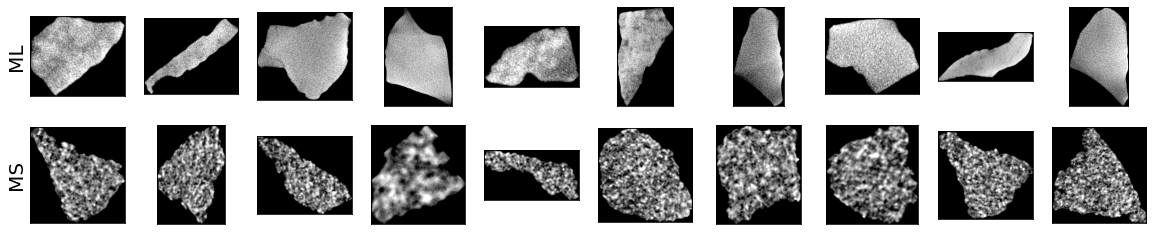

In [49]:
# Raw 

transforms = tf.Compose(
        [   
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    im, label = trainDataset.__getitem__(i_)

    ax.imshow(im[0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(im[0].numpy())
    im.save(f"samples/Test/bbox/raw/{dict_[int(label.numpy())]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[int(label.numpy())]}", fontsize=20)

plt.savefig(f"samples/Test/bbox/raw.png")

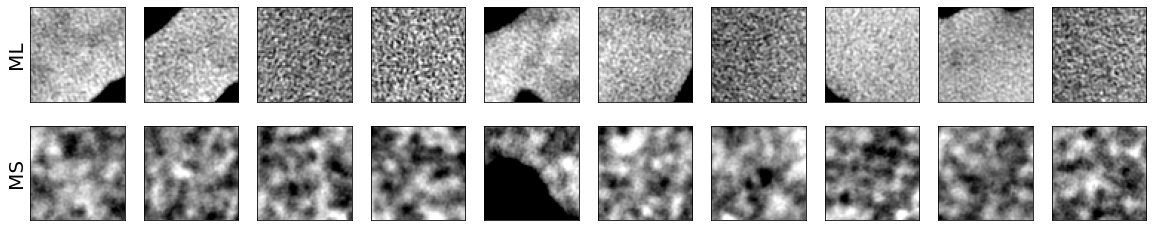

In [50]:
# Cropped 

transforms = tf.Compose(
        [   
            tf.CenterCrop(64),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/bbox/cropped/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/bbox/cropped.png")

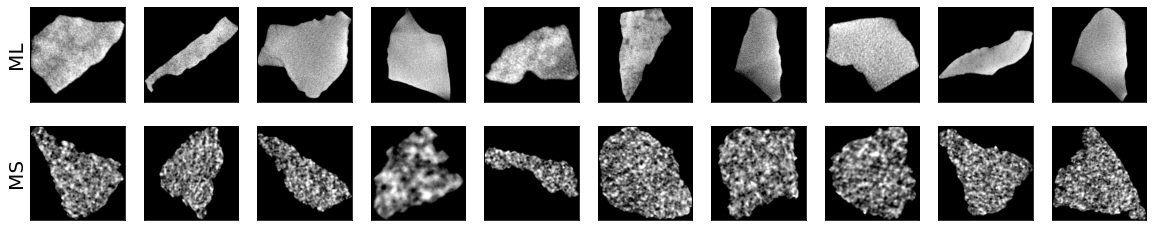

In [51]:
# Padded

transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/bbox/padded/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/bbox/padded.png")

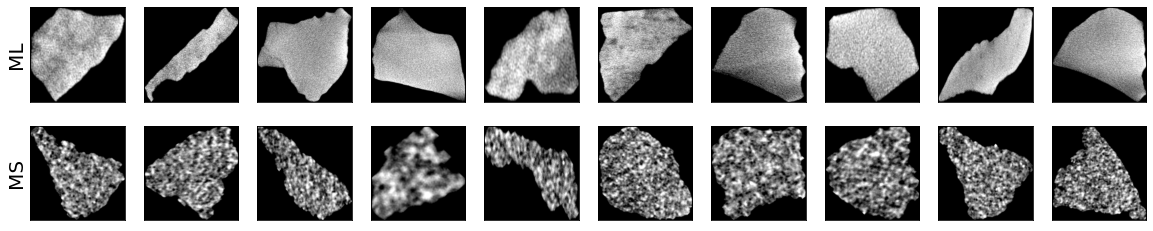

In [52]:
# Resized

transforms = tf.Compose(
        [   
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/bbox/resized/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/bbox/resized.png")

### Test for MAR dataset

In [53]:
dataframe = pd.read_csv('../Dataset/test_mar.csv',index_col=0)
dataframe = dataframe.groupby('Label').sample(10,replace=True,random_state=0).reset_index(drop=True)

dict_ = {0:'BL',1:'GN',2:'ML',3:'MS',4:'OL'}

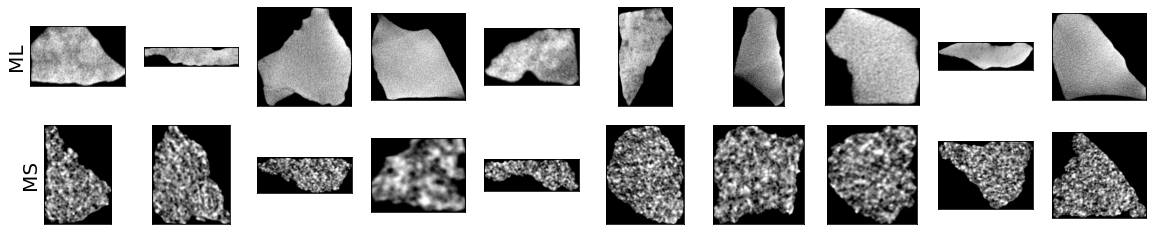

In [54]:
# Raw 

transforms = tf.Compose(
        [   
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    im, label = trainDataset.__getitem__(i_)

    ax.imshow(im[0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(im[0].numpy())
    im.save(f"samples/Test/mar/raw/{dict_[int(label.numpy())]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[int(label.numpy())]}", fontsize=20)

plt.savefig(f"samples/Test/mar/raw.png")

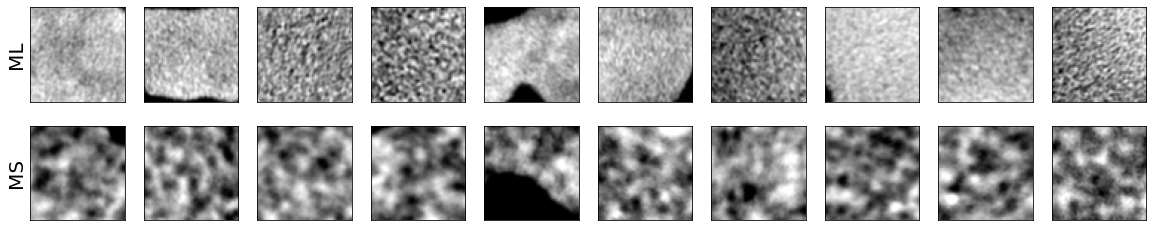

In [55]:
# Cropped 

transforms = tf.Compose(
        [   
            tf.CenterCrop(64),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/mar/cropped/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/mar/cropped.png")

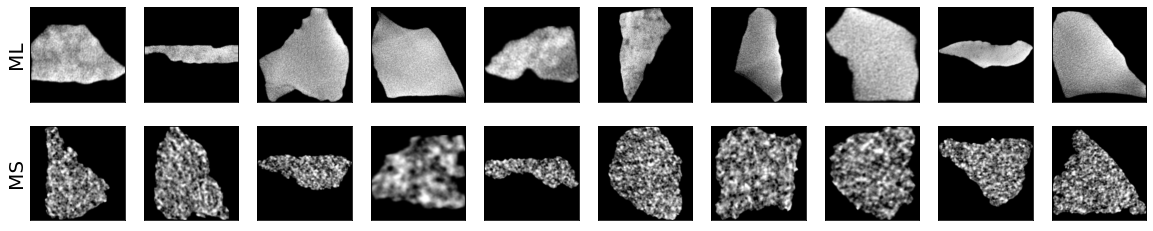

In [56]:
# Padded

transforms = tf.Compose(
        [   
            Padding(out_shape=256),            
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/mar/padded/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/mar/padded.png")

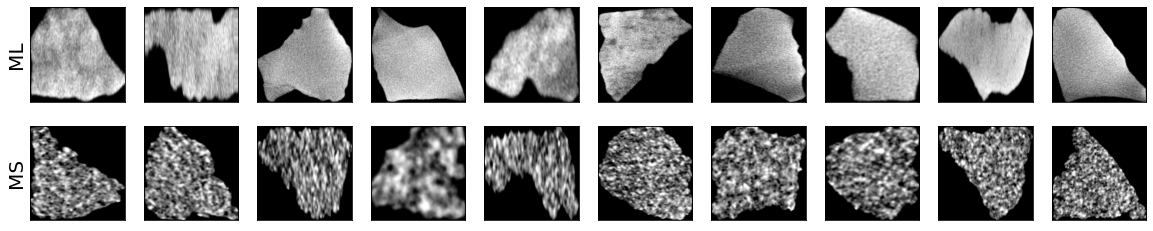

In [57]:
# Resized

transforms = tf.Compose(
        [   
            tf.Resize((256,256)),
            MinMaxNormalization(),
            tf.ToTensor(),
        ])

trainDataset = Dataset(dataframe,transforms=transforms)

train_dataloader = torch.utils.data.DataLoader(trainDataset, batch_size=10*2)

train_features, train_labels = next(iter(train_dataloader))

fig, axs = plt.subplots(2,10,figsize=(20,4))

axs = axs.ravel()

for i_, ax in enumerate(axs):
    ax.imshow(train_features.numpy()[i_][0],cmap='gray')
    #ax.set_title(train_labels.numpy()[i_])
    ax.set_xticks([])
    ax.set_yticks([])

    # Save sample
    im = Image.fromarray(train_features.numpy()[i_][0])
    im.save(f"samples/Test/mar/resized/{dict_[train_labels.numpy()[i_]]}_{i_}.tiff")

    if i_ % 10 == 0:
        ax.set_ylabel(f"{dict_[train_labels.numpy()[i_]]}", fontsize=20)
    
plt.savefig(f"samples/Test/mar/resized.png")